# jointcal photometric residual plots

This notebook contains a collection of debugging plots for jointcal's internal photometric residual values. These are not "publication quality" plots, but some may be turned into better QA plots later on.

In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

import itertools
import numpy as np

import astropy.io.ascii
import astropy.table
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})

# You have to `setup jointcal` and `setup obs_MY_DATAS_OBS_PACKAGE` before starting this notebook
import lsst.daf.persistence
import lsst.afw.geom
import lsst.afw.image
import lsst.afw.cameraGeom.utils

In [2]:
def colorbar(mappable):
    """Stolen from: http://joseph-long.com/writing/colorbars/"""
    try:
        # QuadContourSet is not a Artist, so doesn't have `axes`
        ax = mappable.axes
    except AttributeError:
        ax = mappable.ax
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

## data

Read in the chi2 contributions files output by jointcal and extract the unique visits.

To produce these files, set `config.writeChi2ContributionFiles=True` when running jointcal. The built-in example plots here are from running `JointcalTestCFHT.test_jointcalTask_2_visits_constrainedPhotometry_no_astrometry` with that config turned on. It will also generate `photometry_*_chi2-TRACT_FILTER-ref.csv` files, which contain the residuals measured against the reference stars.

Residual in this context means "difference between measuredStar its fittedStar". See the `PhotometryFit.saveChi2MeasContributions()` method for exactly how the values are calcuated.

In [3]:
# initial = astropy.io.ascii.read('/data/validate/jointcal-hsc/photometry_initial_chi2-0_i-meas.csv')
# final = astropy.io.ascii.read('/data/validate/jointcal-hsc/photometry_final_chi2-0_i-meas.csv')
initial = astropy.io.ascii.read('../tests/photometry_initial_chi2-0_r-meas.csv')
final = astropy.io.ascii.read('../tests/photometry_final_chi2-0_r-meas.csv')

for col,comment in zip(initial.colnames, initial.meta['comments'][0].split('\t')):
    print("%s: %s"%(col, comment))
print()

# we'll need this later
visits = np.unique(final['visit'])
chips = np.unique(final['chip'])
print(visits)
print()
print(chips)

id: id in source catalog
xccd: coordinates in CCD
yccd: 
mag: rough mag
instFlux: measured instrument flux (ADU)
instFluxErr: measured instrument flux error
inputFlux: measured flux (maggies)
inputFluxErr: measured flux error
transformedFlux: 
transformedFluxErr: 
fittedFlux: fitted flux (maggies)
mjd: modified Julian date of the measurement
color: currently unused
fsindex: unique index of the fittedStar
ra: on-sky position of fitted star
dec: 
chi2: contribution to Chi2 (1 dof)
nm: number of measurements of this FittedStar
chip: chip id
visit: visit id

visit 
------
849375
850587

chip
----
  12
  13
  14
  21
  22
  23


## basic histograms

If jointcal is operating correctly, the final residuals (transformedFlux - fittedFlux) should be markedly more peaked toward 0 than the initial residuals (inputFlux - fittedFlux) computed from the read-in PhotoCalib.

Note however that `inputFlux - fittedFlux` for the initial data really just tells you how far apart each flux is from the average value. There will be a number of stars with a residual of 0 because they only have a reference star (which we are not comparing with here). We can get rid of those by restricting to sources with more than one measurement.

In [4]:
def make_comparison_hist(initial, final, bins=50, cut=None):
    """Histograms for initial vs. final values, cut to cut nanomaggies."""
    plt.figure()
    palette = itertools.cycle(sns.color_palette())

    if cut is not None:
        test1 = (-cut*1e-9 < initial) & (initial < cut*1e-9)
        test2 = (-cut*1e-9 < final) & (final < cut*1e-9)
    else:
        test1 = np.ones(initial.shape, dtype=bool)
        test2 = np.ones(final.shape, dtype=bool)

    color = next(palette)
    sns.distplot(initial[test1]*1e9, bins=50, color=color, label='initial')
    plt.axvline(initial[test1].mean()*1e9, linestyle='dashed', linewidth=2, c=color)

    color = next(palette)
    sns.distplot(final[test2]*1e9, bins=50, color=color, label='final')    
    plt.axvline(final[test2].mean()*1e9, linestyle='dashed', linewidth=2, c=color)
    
    plt.xlabel("flux residual (nanomaggies)")
    plt.ylabel('number')
    plt.legend()
    plt.tight_layout()

<IPython.core.display.Javascript object>


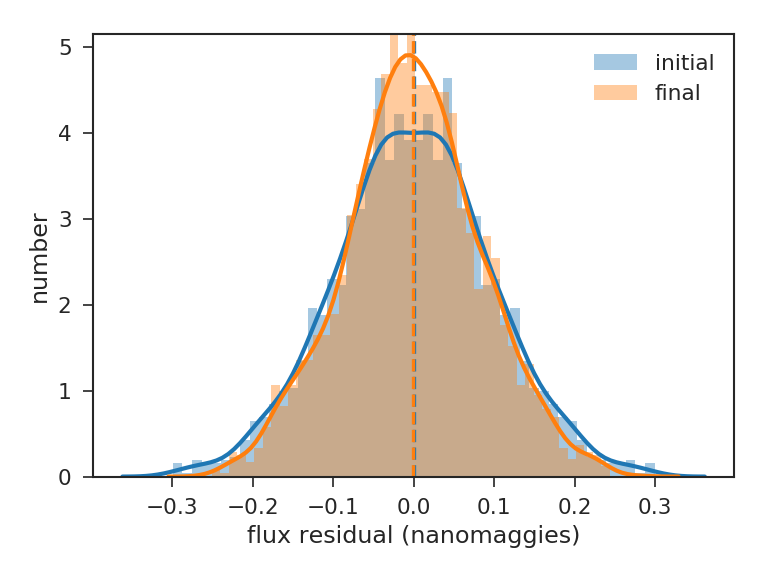

In [5]:
test = initial['nm'] > 1
make_comparison_hist(initial[test]['inputFlux']-initial[test]['fittedFlux'], final['transformedFlux']-final['fittedFlux'], cut=0.3)

### histograms separated by visit or chip

Plotting similar histograms with the visits separated to look for obviously outlier visits or chips.

In [6]:
def make_initial_final_hist(initial, final, initial_targets, final_targets, targets, xlabel="VALUE (UNITS)", bins=50, cut=None):
    """Histograms per target (chip or visit), initial/final on left/right, restricted to +/-cut nanomaggies."""

    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    palette = itertools.cycle(sns.color_palette())

    for target in targets:
        test1 = (initial_targets == target)
        if cut is not None:
            test1 &= (-cut*1e-9 < initial) & (initial < cut*1e-9)
        test2 = (final_targets == target)
        if cut is not None:
            test2 &= (-cut*1e-9 < final) & (final < cut*1e-9)

        color = next(palette)

        sns.distplot(initial[test1]*1e9, bins=50, color=color, label='%s'%target, ax=axes[0], kde=False)
        axes[0].axvline(initial[test1].mean()*1e9, linestyle='dashed', linewidth=2, c=color)

        sns.distplot(final[test2]*1e9, bins=50, color=color, label='%s'%target, ax=axes[1], kde=False)
        axes[1].axvline(final[test2].mean()*1e9, linestyle='dashed', linewidth=2, c=color)

    axes[0].set_xlabel('initial %s'%xlabel)
    axes[1].set_xlabel('final %s'%xlabel)
    axes[0].set_ylabel('normalized number')
    plt.legend()
    plt.tight_layout()
    fig.subplots_adjust(wspace=0)

<IPython.core.display.Javascript object>


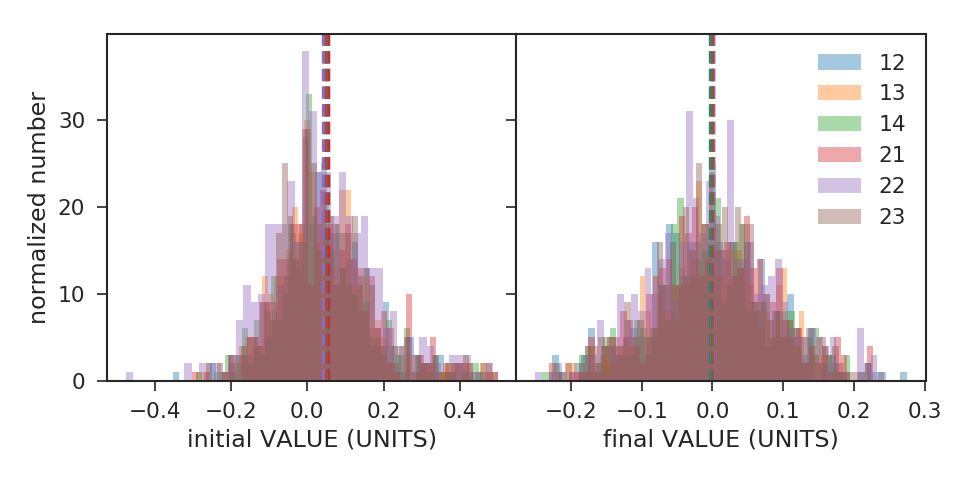

In [7]:
make_initial_final_hist(initial['transformedFlux']-initial['fittedFlux'], final['transformedFlux']-final['fittedFlux'],
                                                initial['chip'], final['chip'], chips, cut=0.5)

<IPython.core.display.Javascript object>


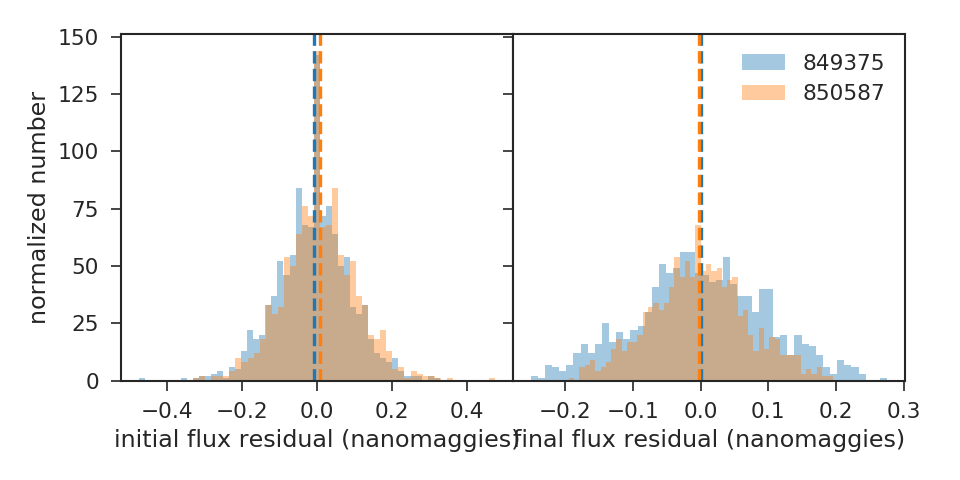

In [8]:
make_initial_final_hist(initial['inputFlux']-initial['fittedFlux'],
                        final['transformedFlux']-final['fittedFlux'],
                        initial['visit'], final['visit'], visits,
                        'flux residual (nanomaggies)', cut=0.5)

In [9]:
def make_hist(data, visit_list, xlabel="VALUE (UNITS)", bins=50, cut=None):
    """Separate histograms for each visit, cut to some number of nanomaggies."""
    plt.figure()
    palette = itertools.cycle(sns.color_palette())
    for visit in visits:
        test = (visit_list == visit)
        if cut is not None:
            test &= (-cut*1e-9 < data) & (data < cut*1e-9)
        color = next(palette)
        sns.distplot(data[test]*1e9, bins=50, color=color, label='%s'%visit)
        mean = np.median(data[test])*1e9
        print('%s median: %s'%(visit, mean))
        plt.axvline(mean, linestyle='dashed', linewidth=2, c=color)
    plt.xlabel(xlabel)
    plt.ylabel('number')
    plt.legend()
    plt.tight_layout()

<IPython.core.display.Javascript object>


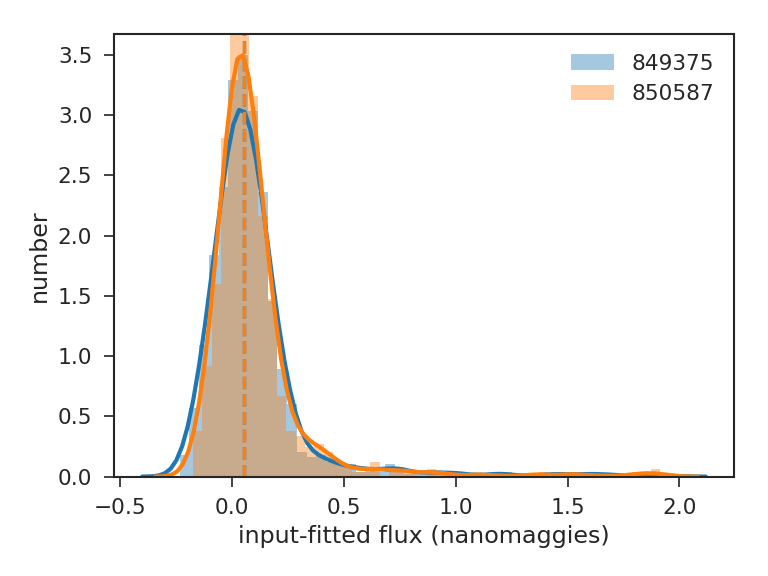

849375 median: 0.053896825
850587 median: 0.05655889


<IPython.core.display.Javascript object>


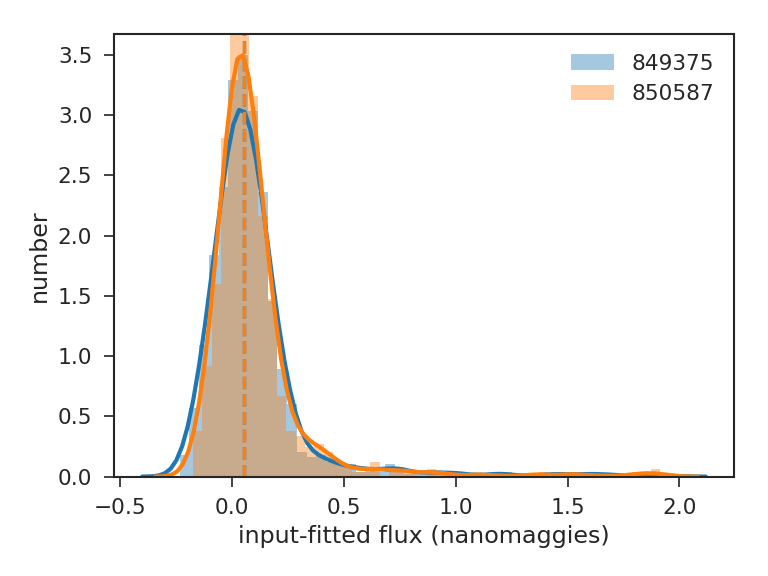

849375 median: 0.053896825
850587 median: 0.05655889


<IPython.core.display.Javascript object>


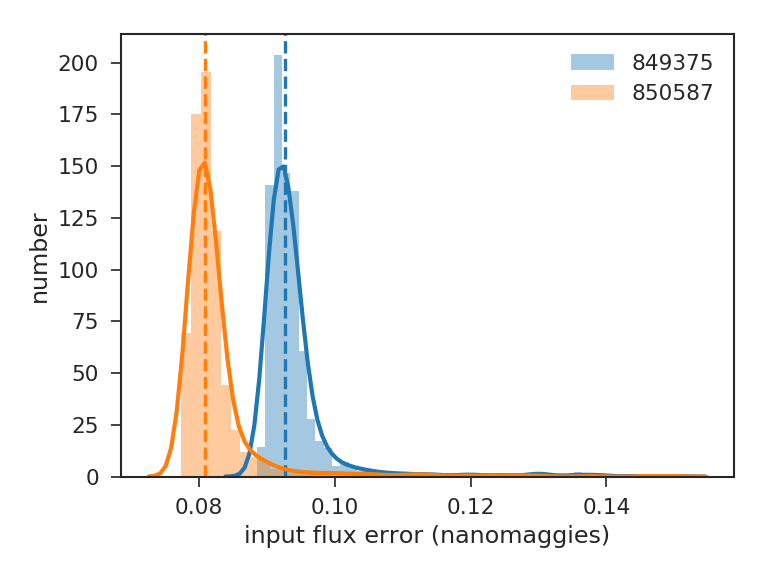

849375 median: 0.0926745687
850587 median: 0.0809417164


<IPython.core.display.Javascript object>


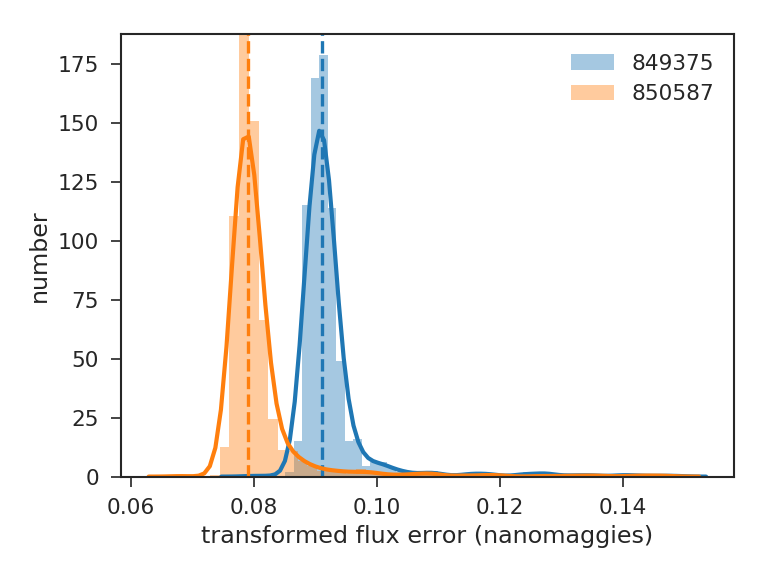

849375 median: 0.09110893465
850587 median: 0.0790492535


In [10]:
make_hist(final['inputFlux']-final['fittedFlux'], final['visit'], 'input-fitted flux (nanomaggies)', cut=2)
make_hist(final['inputFlux']-final['fittedFlux'], final['visit'], 'input-fitted flux (nanomaggies)', cut=2)
# make_hist(initial['transformedFlux']-final['fittedFlux'], final['visit'], 'transformed-fitted flux (nanomaggies)')
make_hist(final['inputFluxErr'], final['visit'], 'input flux error (nanomaggies)', cut=0.15)
make_hist(final['transformedFluxErr'], final['visit'], 'transformed flux error (nanomaggies)', cut=0.15)

## Playing with astropy.join

`astropy.table.join` lets us match on some set of keys to join between the initial and final data. That way we can do direct comparisons of the objects that survived the outlier rejection process.

In particular, the ratio of `initial['inputFlux'] / final['transformedFlux']` tells us about the bulk shift in photometry during the fitting process.

In [11]:
matched = astropy.table.join(initial, final, keys=['id','visit','chip'])

<IPython.core.display.Javascript object>


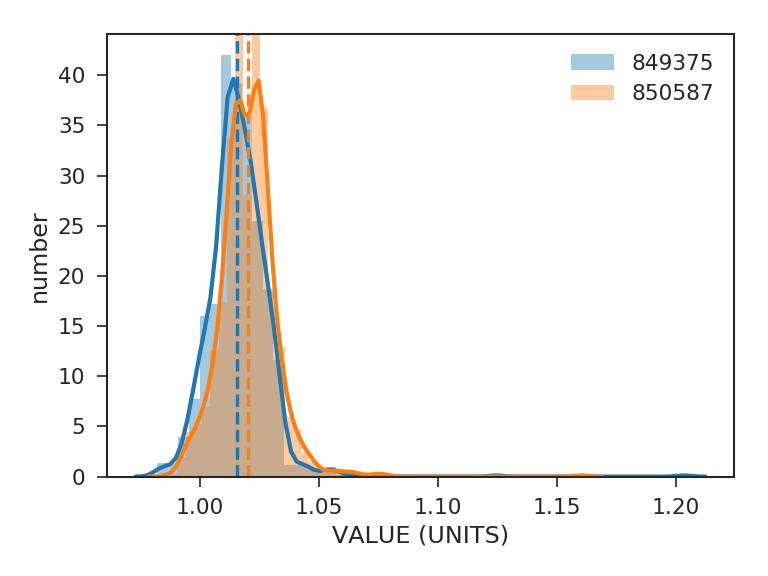

849375 median: 1.01537034006
850587 median: 1.02021358638


In [12]:
make_hist(matched['inputFlux_1'] / matched['transformedFlux_2']/1e9, matched['visit'])

## On-sky dependence

The magnitudes of the final flux residuals should not have any obvious structure, and should be closer to zero overall than the initial residuals. How much better depends on the number of visits that were included in the fit.

In [15]:
def plot_fluxes(initial, final):
    """Plot the flux deltas on the focal plane."""
    visits = np.unique(initial['visit'])
    deg_to_mas = 3.6e6
    size = 5
    cmap = 'RdBu'
    colormax = 0.3
    
    for visit in visits:
        cuti = initial[(initial['visit'] == visit)]
        cutf = final[(final['visit'] == visit)]
        print("visit %d initial total, cut: %d, %d"%(visit, len(initial), len(cuti)))
        print("visit %d final total, cut: %d, %d"%(visit, len(final), len(cutf)))
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
        axes[0].set_title('initial')
        axes[1].set_title('final')


        axes[0].scatter(cuti['ra'], cuti['dec'], c=(cuti['inputFlux']-cuti['fittedFlux'])*1e9,
                        s=size, cmap=cmap, vmin=-colormax, vmax=colormax)
        axes[0].set_ylabel("dec")
        axes[0].set_xlabel("ra")

        ax = axes[1].scatter(cutf['ra'], cutf['dec'], c=(cutf['transformedFlux']-cutf['fittedFlux'])*1e9,
                             s=size, cmap=cmap, vmin=-colormax, vmax=colormax)
        axes[1].set_xlabel("ra")
        
        fig.suptitle('visit: %d'%visit)
        
        cbar = colorbar(ax)
        cbar.set_label('flux delta (nanomaggies)', rotation=270, labelpad=15)
        fig.tight_layout()
        fig.subplots_adjust(wspace=0)

visit 849375 initial total, cut: 2334, 1166
visit 849375 final total, cut: 2310, 1147


<IPython.core.display.Javascript object>


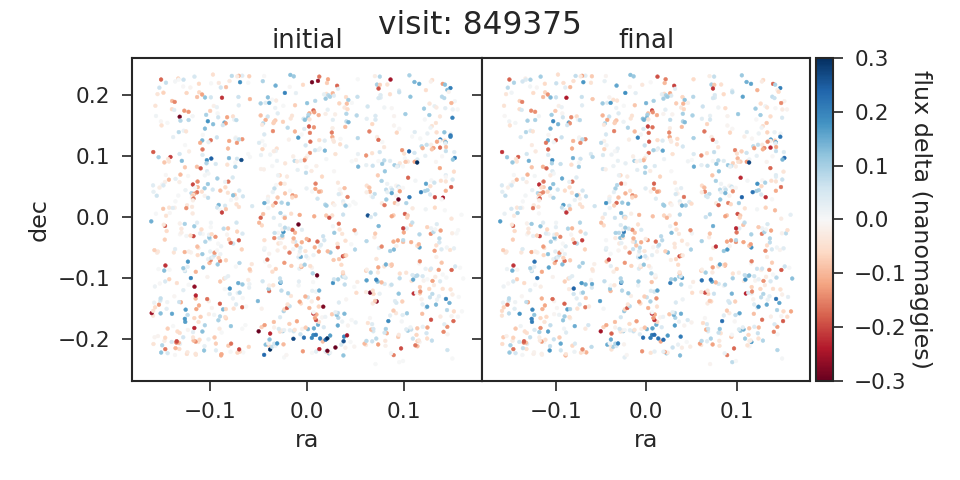

visit 850587 initial total, cut: 2334, 1168
visit 850587 final total, cut: 2310, 1163


<IPython.core.display.Javascript object>


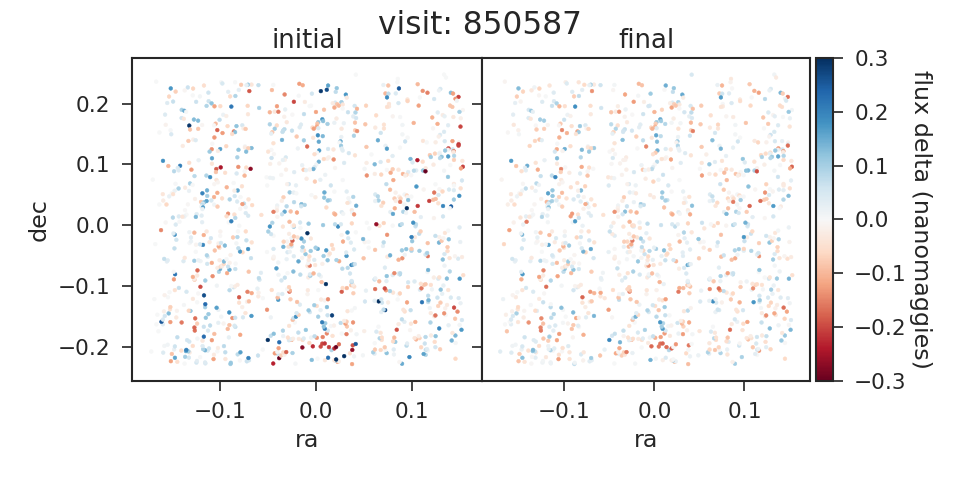

In [16]:
plot_fluxes(initial, final)